In [1]:
# установка ignite (он предустановлен только на kaggle)
%pip install pytorch-ignite 

In [ ]:
# Основные параметры вынесены сюда для удобного изменения
author = "provitia" # заменит некоторые названия чекпойнтов и вывода, обязательно поменяйте имя на своё

checkpointname = "" # имя файла чекпойнта. программа будет искать его в папке submission-{автор}-data. Если такого файла нет, шаг загрузки чекпойнта пропускается
checkpointflag = True # поставьте на True, если хотите загрузить чекпойнт, иначе False. это происходит до обучения
trainflag = True # поставьте на True если хотите тренировать модель, иначе False
testflag = True # поставьте на True если хотите тестировать модель (вывести submission-{автор}.csv), иначе False


infolder = "" # пишите пустую строку, если запускаете у себя на машине; /kaggle/input/ если в кэггле; в колабе не знаю (попробуйте пустую)
outfolder = "" # пишите пустую строку, если запускаете у себя на машине; /kaggle/working/ если в кэггле; в колабе не знаю (попробуйте пустую)

BATCH_SIZE = 10
MAX_EPOCHS = 50 # учтите, что эпохи сохраняются на чекпойнтах, а не сбрасываются.

train_valid_frac = [0.9, 0.1] # в каких пропорциях делить трейн и валидацию. пример с 90%:10%


# Остальное (аугментации, модель, различные оптимизаторы) ищите ниже.

torch.Size([3, 50, 88])

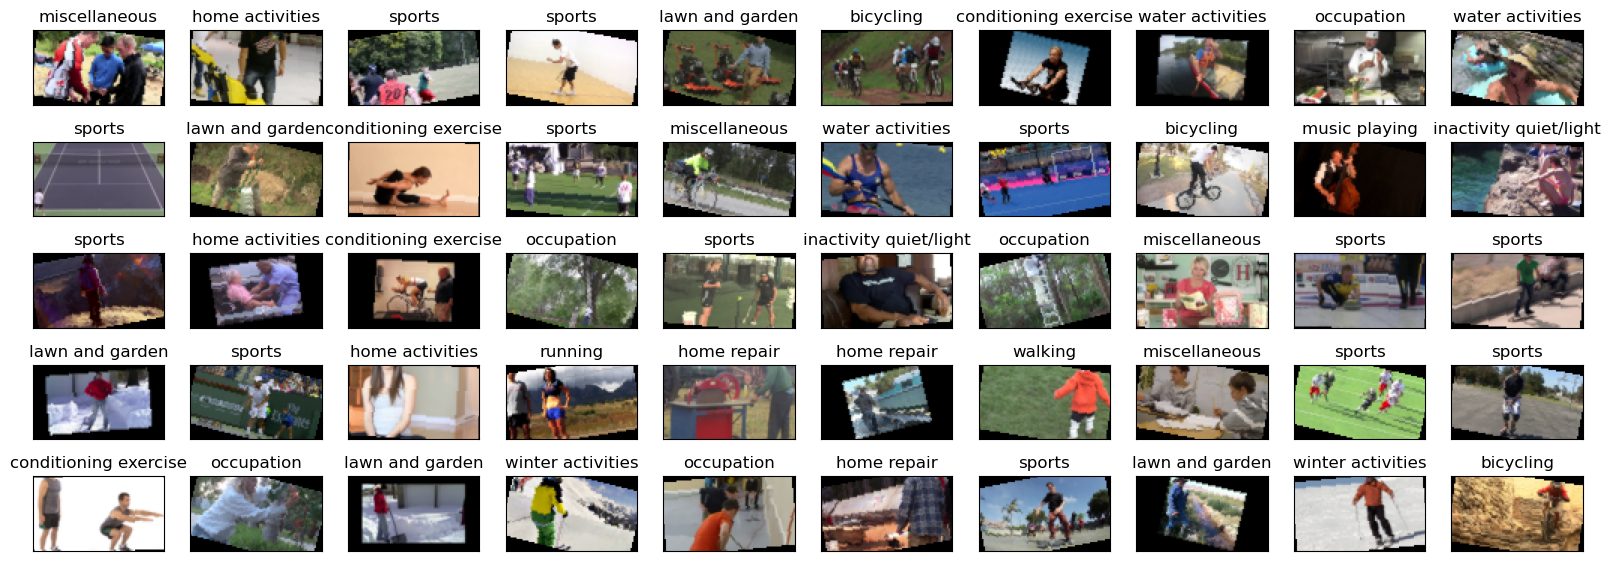

In [17]:
import torch
import pandas as pd
import numpy as np
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# класс для поддержки датасетов, где ответы (labels) хранятся в файле .csv а не в названиях папок
# при создании объекта CustomDataset указывайте режим train или test (по умолчанию train)
# это влияет на поведение __getitem__: при train он возвращает картинку и ответ
# а при test - картинку и номер файла для заполнения .csv файла
class CustomDataset(Dataset):
    def __init__(self, image_dir, answers_file=None, transform=None, mode="train"):
        self.image_dir = image_dir
        self.mode = mode
        if self.mode == "train":
            self.answers_df = pd.read_csv(answers_file)
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_dir))
    
    def __getitem__(self, index):
        filename = str(self.answers_df.iloc[index, 0]) + ".jpg" if self.mode == "train" else list(os.walk(self.image_dir))[0][2][index]
        img_name = os.path.join(self.image_dir, filename)
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        if self.mode == "train":
            label = self.answers_df.iloc[index, 1]
            return image, label
        filename_index = int(filename.split(".")[0])
        return image, filename_index


# ВАШИ АУГМЕНТАЦИИ СЮДА (transform). Вот пример:
downscale_mult = .85 # 15% обрезки по краям
transform = transforms.Compose([
    transforms.CenterCrop([int(720 * downscale_mult), int(1280 * downscale_mult)]),
    transforms.Resize(50),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

# загружаем датасет
infolder_dataset = (infolder + "ml-intensive-yandex-academy-spring-2025/") if "kaggle" in infolder else infolder # поправка названия папки для kaggle
dataset_train = CustomDataset(f"{infolder_dataset}human_poses_data/img_train", f'{infolder_dataset}human_poses_data/train_answers.csv', transform=transform)
# для вычислений моей модели понадобилось форма изображения, вам может и не понадобиться
image_shape = dataset_train[0][0].shape

# названия классов для визуализации
class_names = pd.read_csv(f"{infolder_dataset}human_poses_data/activity_categories.csv")['category']

# предпросмотр датасета
plt.figure(figsize=(20, 7))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(dataset_train[i][0].permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[dataset_train[i][1]])
    
image_shape

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # переходим на GPU если можно
device

device(type='cuda')

In [5]:
from torch import nn
from torchinfo import summary



# Ваша модель сюда. Вот пример Resnet со вспомогательным классом BasicBlockWithSkip (его можно удалить)
class BasicBlockWithSkip(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(BasicBlockWithSkip, self).__init__()

    self.block = nn.Sequential(
        # bias=False, т.к. есть батч нормы
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    self.shortcut = nn.Sequential(
        # bias=False, т.к. есть батч нормы
        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x):
    return nn.ReLU()(self.block(x) + self.shortcut(x))

model = nn.Sequential(
    BasicBlockWithSkip(3, 16),
    nn.MaxPool2d(2, 2),

    BasicBlockWithSkip(16, 64),
    nn.MaxPool2d(2, 2),

    BasicBlockWithSkip(64, 128),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(8448, 500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(500, 20),
)


# выводим summary модели
summary(model, [1] + list(image_shape))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 20]                   --
├─BasicBlockWithSkip: 1-1                [1, 16, 50, 88]           --
│    └─Sequential: 2-1                   [1, 16, 50, 88]           --
│    │    └─Conv2d: 3-1                  [1, 16, 50, 88]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 50, 88]           32
│    │    └─ReLU: 3-3                    [1, 16, 50, 88]           --
│    │    └─Conv2d: 3-4                  [1, 16, 50, 88]           2,304
│    │    └─BatchNorm2d: 3-5             [1, 16, 50, 88]           32
│    └─Sequential: 2-2                   [1, 16, 50, 88]           --
│    │    └─Conv2d: 3-6                  [1, 16, 50, 88]           48
│    │    └─BatchNorm2d: 3-7             [1, 16, 50, 88]           32
├─MaxPool2d: 1-2                         [1, 16, 25, 44]           --
├─BasicBlockWithSkip: 1-3                [1, 64, 25, 44]           --
│    └─Sequ

In [6]:
from torch.utils.data import random_split

# объявляем оптимайзер и лосс
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=.9)
criterion = nn.CrossEntropyLoss()

# делим на трейн и валидацию
train_set, valid_set = random_split(dataset_train, train_valid_frac)

# создаём лоадеры для теста и валидации
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

In [7]:
# используем pytorch ignite вместо бойлерплейта в ванильном торче
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Fbeta, Precision, Recall

trainer = create_supervised_trainer(model, optimizer, criterion, device)

precision = Precision(average=False)
recall = Recall(average=False)

# отслеживаем 3 метрики: accuracy, loss и f1 
metrics = {
    "loss": Loss(criterion),
    "accuracy": Accuracy(),
    "f1": Fbeta(beta=1.0, average=True, precision=precision, recall=recall) # F1 это и есть Fbeta с beta=1.0
}

train_evaluator = create_supervised_evaluator(model, metrics, device)
valid_evaluator = create_supervised_evaluator(model, metrics, device)

In [ ]:
# логгинг, позаимствованный с семинара
from ignite.engine import Events
from IPython.display import clear_output

metrics_history = {"Train": [], "Valid": []}

def log_iter_loss(engine):
  print(f"EPOCH {engine.state.epoch} - Iter {engine.state.iteration}: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=100), log_iter_loss)

def compute_epoch_results(engine):
  train_evaluator.run(train_loader),
  valid_evaluator.run(valid_loader)


def show_stats():
  # изображаем изменения метрик в виде графика
  plt.figure(figsize=(20, 4))
  names = ["Loss", "Accuracy", "F1"]
  for i, name in enumerate(names):
    plt.subplot(1, 3, i+1)
    plt.title(name)
    stats = [[], []]
    
    for k in metrics_history["Train"]:
      stats[0].append(k[i])
    for k in metrics_history["Valid"]:
      stats[1].append(k[i])
    r = range(1, len(stats[0])+1)
    plt.plot(r, stats[0])
    plt.plot(r, stats[1])
    plt.legend([f"Train {name}", f"Valid {name}"])

  plt.show()

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine, label=""):
  if label == "Train":
    clear_output()
  print(f"[{label}]: {', '.join([f'{k}={v}' for k, v in engine.state.metrics.items()])}")
  metrics_history[label].append(list(engine.state.metrics.values()))
  if len(metrics_history["Train"]) == len(metrics_history["Valid"]):
    show_stats()

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

In [9]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler


# Динамическое уменьшение LR, если лосс не меняется. Настройте под себя
scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5, # уменьшить лр вдвое
    patience=2, # если последние 2 эпохи не было уменьшения лосса
    threshold=0.05 # на 0.05
)

def log_lr():
  for param_group in optimizer.param_groups:
    print(f"Learning rate: {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, log_lr)

In [10]:
from ignite.handlers import EarlyStopping

# Ранняя остановка модели. Настройте под себя
# сейчас останавливает модель если 10 эпох не было улучшения
early_stopping = EarlyStopping(patience=10, score_function=lambda engine: -criterion(*engine.state.output), trainer=trainer)
valid_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
train_evaluator.add_event_handler(Events.COMPLETED, early_stopping)

In [11]:
from ignite.handlers import Checkpoint, DiskSaver

# Логика чекпойнтов
def create_checkpoint(trainer, model, optimizer):
    to_save = {
        "model": model,
        "optimizer": optimizer,
        "trainer": trainer,
        "early_stopping": early_stopping,
        "scheduler": scheduler
    }
    checkpoint_handler = Checkpoint(
        to_save,
        DiskSaver(f"submission-{author}-data", create_dir=True, require_empty=False),
        n_saved=10, # Сколько последних чекпойнтов сохранять
    )
    return checkpoint_handler

# Создаем чекпойнт обработчик
checkpoint_handler = create_checkpoint(trainer, model, optimizer)

# Добавляем обработчик на событие завершения эпохи
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler)

In [ ]:
if checkpointflag and checkpointname and os.path.exists(f"{infolder}submission-{author}-data/{checkpointname}"):
    # загружаем чекпойнт
    print("Attempting to load a checkpoint")
    checkpoint = torch.load(f"{infolder}submission-{author}-data/{checkpointname}", weights_only=False)
    Checkpoint.load_objects(checkpoint=checkpoint, to_load={"model": model, "optimizer": optimizer, "trainer": trainer,
                                                            "early_stopping": early_stopping, "scheduler": scheduler})

[Valid]: loss=2.5687841415405273, accuracy=0.35, f1=0.07833333333333325


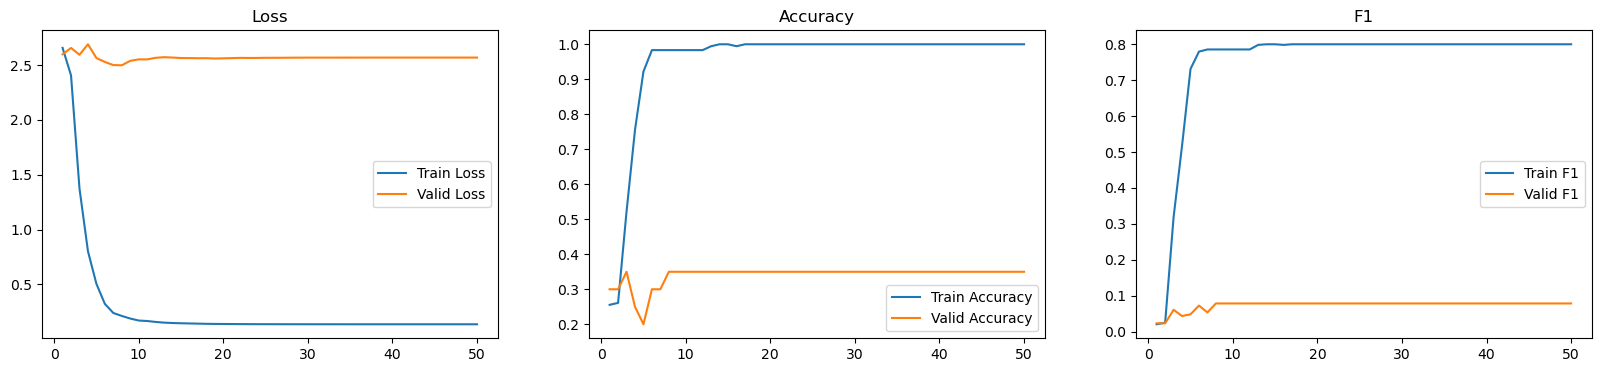

Learning rate: 1.52587890625e-08


In [ ]:
if trainflag:
    print("Beginning training")
    trainer.run(train_loader, max_epochs=MAX_EPOCHS)

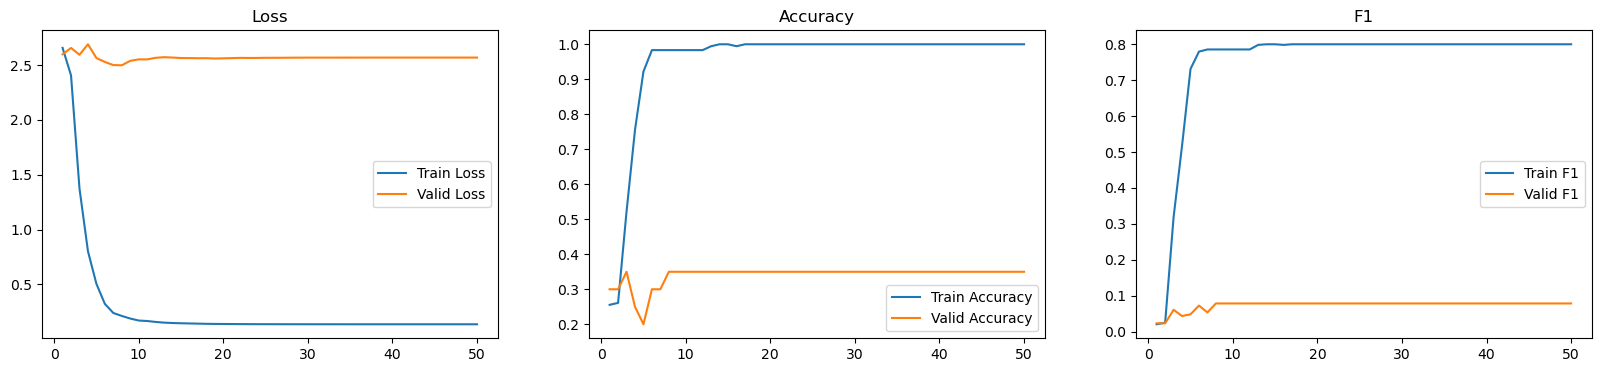

In [14]:
show_stats()

In [ ]:
if testflag:
    # загружаем тестовые данные
    print("Beginning testing")
    dataset_train = CustomDataset(f"{infolder_dataset}human_poses_data/img_test", mode="test", transform=transform)
    test_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE)

    model.eval()

    # создаём DataFrame для хранения csv данных
    cols = ['id', 'target_feature']
    answers = pd.DataFrame(columns=cols)

    for batch in test_loader:
        pred = model(batch[0].to(device=device)) # делаем предикт на батч
        pred = torch.argmax(pred, dim=1).detach() # получаем классы (labels) из выходного слоя (берём top1)
        data = np.vstack([batch[1].numpy(), pred.cpu().numpy()]).T # организуем информацию в 2 столбца (кол-во рядов = BATCH_SIZE)
        df = pd.DataFrame(data=data, columns=cols) # создаём dataframe
        if df['target_feature'].isna().sum() != 0:
            print(data)
            print(df)
            raise ValueError("Произошла непридведенная ошибка - найдены нулевые значения. Такого не должно быть в принципе")
        answers = pd.concat([answers, df]) # присоединяем к ответному dataframe

    answers.to_csv(f"{outfolder}submission-{author}.csv", index=False)
    answers